In [118]:
from drivecycle import route, trajectory, utils, plots, graph, energy

import matplotlib.pyplot as plt
import networkx as nx

import psycopg

import requests
import polyline
import json
import pandas as pd
import numpy as np
import requests

import pickle

In [119]:
route_id="15"
valhalla_host = "http://localhost:8002"

In [120]:
conn = psycopg.connect(
        host="localhost",
        dbname="victoria_gtfs",
        user="username",
        password="password",
    )

In [121]:
cur = conn.execute(
    "SELECT DISTINCT ON (trips.shape_id) trips.shape_id,trips.trip_id, trips.direction_id, trips.trip_headsign FROM trips " 
    "JOIN routes ON trips.route_id=routes.route_id "
    "WHERE routes.route_short_name=%s ", (route_id,)
    
)
shapes = cur.fetchall()
shapes

[('1-15-147', 'aa5878544', 1, 'Esquimalt via Fort/Yates Exp'),
 ('1-15-150', 'aa5450463', 1, 'Esquimalt via Fort/Yates Exp'),
 ('1-15-151', 'aa6058786', 1, 'Esquimalt via Fort/Yates Exp'),
 ('1-15-154', 'aa6022634', 0, 'UVic via Foul Bay Exp'),
 ('1-15-155', 'aa5449629', 0, 'UVic via Foul Bay Exp'),
 ('1-15-156', 'aa5449936', 1, 'Esquimalt via Fort/Yates Exp')]

In [148]:
route_index = 1
# route_index = 4
shape = shapes[route_index][0]

cur = conn.execute(
    "SELECT ST_AsGeoJSON(shapes_aggregated.shape) "
    "FROM shapes_aggregated " 
    "WHERE shapes_aggregated.shape_id=%s ", (shape,)
)

line = cur.fetchall()
geojson = json.loads(line[0][0])
coords = [tuple((i[1],i[0])) for i in geojson["coordinates"]]

In [149]:
b = polyline.encode(coords, 6)

data =json.dumps({
    "encoded_polyline":b,
    "costing":"auto",
    "filters":
        {
            "attributes":[
                "edge.way_id",
                "edge.names",
                "edge.length",
                "edge.speed",
                "node.intersecting_edge.road_class",
                "node.intersecting_edge.begin_heading",
                "node.elapsed_time","node.type"
                ],
            "action":"include"
        }
    })

height_data = json.dumps({"encoded_polyline":b,"range":True})

In [150]:
trace = requests.post(f"{valhalla_host}/trace_attributes", data=data)
height = requests.post(f"{valhalla_host}/height", data=height_data)

In [151]:
edges = trace.json()["edges"]

data_ = []

for edge in edges:
    length = edge["length"]*1000
    speed = edge["speed"]
    way_id = edge["way_id"]
    try:
        intersect = [edge["end_node"]["intersecting_edges"][0]["road_class"]]
    except:
        intersect = [None]

    item = {
        "way_id":way_id,
        "length":length,
        "speed":speed,
        "intersection":intersect,
    }
    data_.append(item)

In [152]:
data_

[{'way_id': 275864152,
  'length': 32.0,
  'speed': 25,
  'intersection': ['service_other']},
 {'way_id': 63971455,
  'length': 42.0,
  'speed': 40,
  'intersection': ['service_other']},
 {'way_id': 63971455,
  'length': 16.0,
  'speed': 40,
  'intersection': ['tertiary']},
 {'way_id': 4282740,
  'length': 22.0,
  'speed': 40,
  'intersection': ['service_other']},
 {'way_id': 4282740,
  'length': 64.0,
  'speed': 40,
  'intersection': ['service_other']},
 {'way_id': 4282740,
  'length': 7.0,
  'speed': 40,
  'intersection': ['service_other']},
 {'way_id': 4282740,
  'length': 57.0,
  'speed': 40,
  'intersection': ['tertiary']},
 {'way_id': 4282740,
  'length': 10.0,
  'speed': 40,
  'intersection': ['service_other']},
 {'way_id': 4282740,
  'length': 5.0,
  'speed': 40,
  'intersection': ['service_other']},
 {'way_id': 4282740,
  'length': 16.0,
  'speed': 40,
  'intersection': ['tertiary']},
 {'way_id': 4282740,
  'length': 130.0,
  'speed': 40,
  'intersection': ['service_other']},


In [153]:
cur = conn.execute("""
    SELECT ST_LineLocatePoint(
        ST_SetSRID(shape_return.shape,4326), 
        stop_return.stop_loc::geometry) * 
        ST_Length(
            ST_Transform(
                ST_SetSRID(shape_return.shape,4326),
                3005
            )
        ) 
        FROM
    (
    SELECT stop_times.trip_id, trips.shape_id, stops.stop_loc, stop_times.stop_sequence, stop_times.stop_id FROM stop_times
    JOIN stops ON stop_times.stop_id=stops.stop_id
    JOIN trips ON stop_times.trip_id=trips.trip_id
    WHERE stop_times.trip_id=%s
    ORDER BY stop_times.stop_sequence
    ) AS stop_return
    JOIN (
    SELECT shapes_aggregated.shape, shapes_aggregated.shape_id
    FROM shapes_aggregated
    WHERE shapes_aggregated.shape_id=%s
    ) AS shape_return 
    ON stop_return.shape_id=shape_return.shape_id
    """,
    (shapes[route_index][1],shapes[route_index][0]))

distances = cur.fetchall()
stops = [round(i[0],2) for i in distances]
stops

[0.0,
 842.12,
 1804.89,
 2488.02,
 2977.85,
 3818.32,
 4411.51,
 5167.18,
 5909.0,
 6619.64,
 7113.75,
 7546.18,
 7755.71,
 7907.18,
 8544.82,
 8798.63,
 9036.25,
 9439.25,
 9861.15,
 10192.11,
 10444.78,
 10807.62,
 11209.8,
 11373.51,
 11599.09,
 11861.03,
 12219.04,
 12596.08,
 12840.69,
 13204.44]

In [154]:
a = graph.Graph(data_)
a.include_stops(stops[1:])
a.consolidate_intersections()
a.simplify_graph()
len(a.get_edges())

64

In [155]:
stop_params={"bus_stop":60,"tertiary":120, "secondary":60}
dc = route.sequential(a.get_edges(),stops=stop_params, stop_at_node=True, step=1)
dc

INFO:root:Vi: 11.11. Reducing vf to 12.50 and v_target to 12.50 at time 561.0 and segment length 23.019999999999982
INFO:root:Vi: 0.00. Reducing vf to 12.50 and v_target to 12.50 at time 821.0 and segment length 39.0
INFO:root:Vi: 0.00. Reducing vf to 11.25 and v_target to 11.25 at time 821.0 and segment length 39.0
INFO:root:Vi: 0.00. Reducing vf to 10.12 and v_target to 10.12 at time 821.0 and segment length 39.0
INFO:root:Vi: 0.00. Reducing vf to 9.11 and v_target to 9.11 at time 821.0 and segment length 39.0
INFO:root:Vi: 0.00. Reducing vf to 8.20 and v_target to 8.20 at time 821.0 and segment length 39.0
INFO:root:Could not complete segment: ti: 877.00, tf: 2.96,  vi: 13.89 , vf: 0.00,                                 v_target:13.89, length: 41.18
INFO:root:Vi: 0.00. Reducing vf to 12.50 and v_target to 12.50 at time 1256.96496 and segment length 84.75
INFO:root:Could not complete segment: ti: 1939.96, tf: 3.48,  vi: 11.11 , vf: 0.00,                                 v_target:13.89,

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 5.00000000e-01],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00],
       ...,
       [2.25644076e+03, 3.85222222e+00, 1.29315669e+04],
       [2.25744076e+03, 2.85222222e+00, 1.29349191e+04],
       [2.25844076e+03, 1.85222222e+00, 1.29372713e+04]])

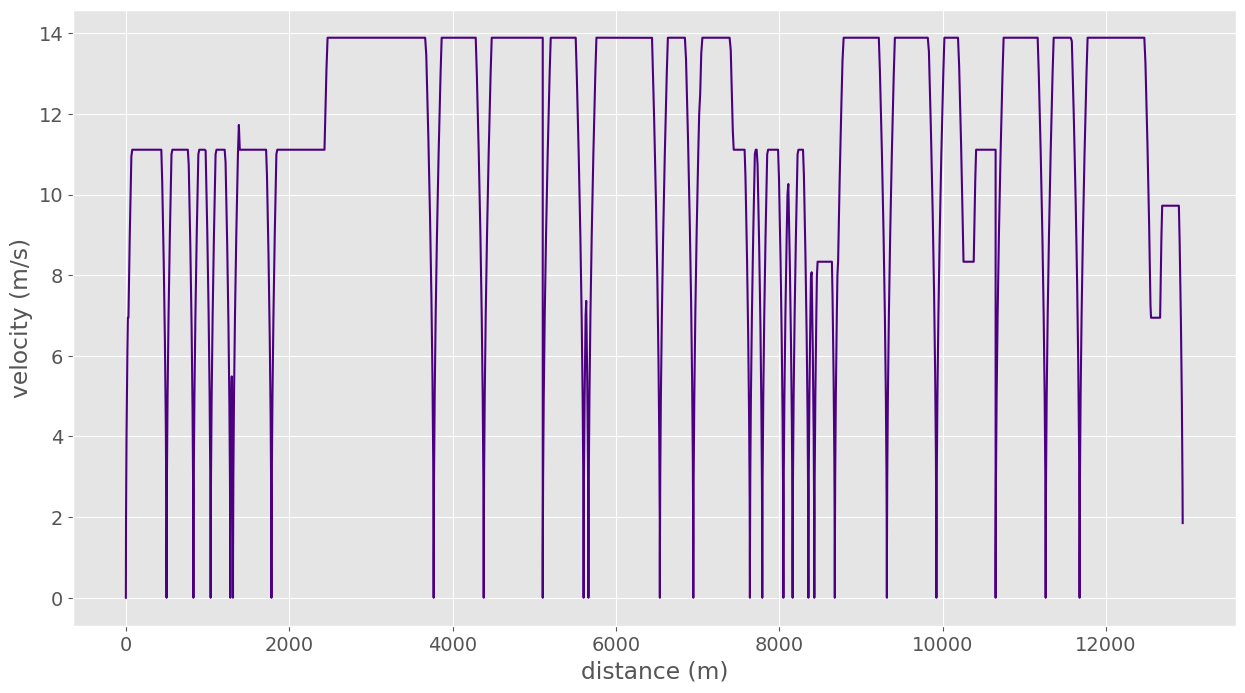

In [157]:
plots.plot_vd(dc,"route_drivecycle.png")

In [163]:
elv = height.json()["range_height"]
soc = energy.energy_model(dc,elv, m=14465, area=8.9, capacity=555)
power
# final = np.c_[dc, power[:,4]]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 5.00000000e-01, 3.37266591e-03,
        9.99993923e-01],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 1.01419097e-02,
        9.99981726e-01],
       ...,
       [2.29741024e+03, 3.19900988e+00, 1.30922001e+04, 1.69843678e+01,
        9.69397536e-01],
       [2.29841024e+03, 2.19900988e+00, 1.30948991e+04, 1.69790246e+01,
        9.69407163e-01],
       [2.29941024e+03, 1.19900988e+00, 1.30965981e+04, 1.69761035e+01,
        9.69412426e-01]])

In [164]:
total_power = soc[-1,3]
total_dist = soc[-1,2]

print(total_power, total_dist)

(total_power/(total_dist/1000))

13.308523207960901 12937.271337526538


1.0286963039383343

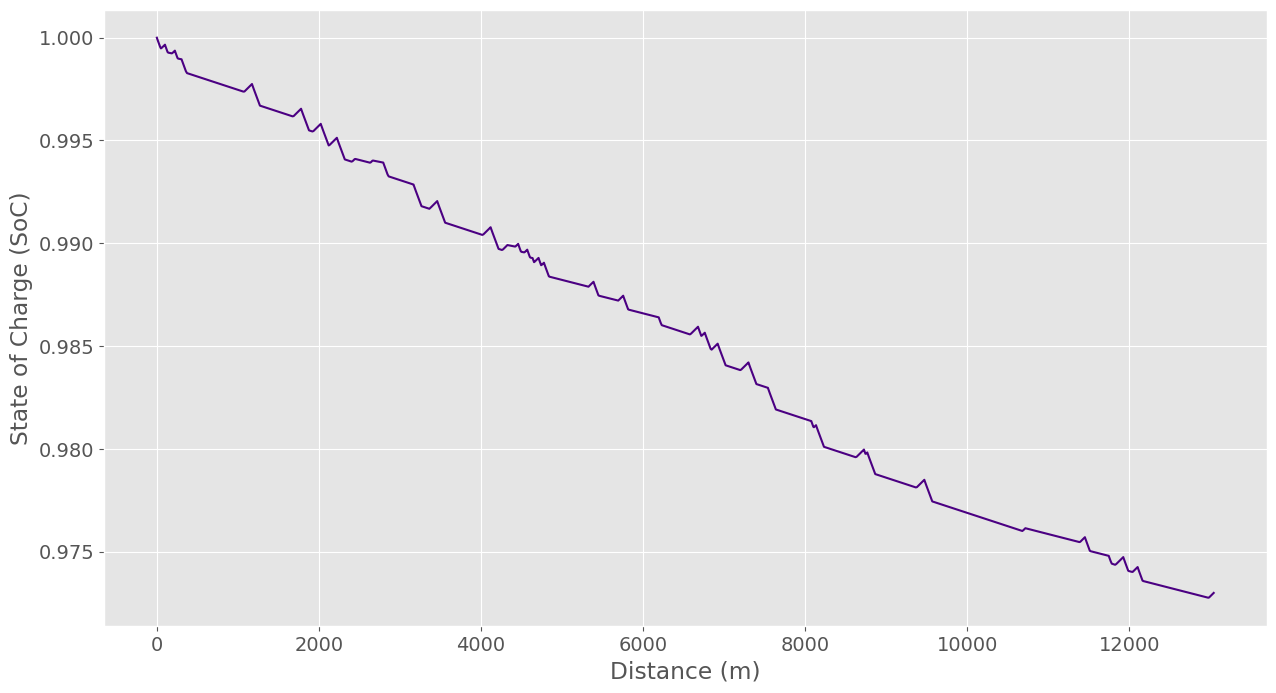

SoC: 0.9694124261404893


In [161]:
t=[i[2] for i in final]
p=[i[3] for i in final]

plt.figure(figsize=(15, 8))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 14})
plt.xlabel("Distance (m)")
plt.ylabel("State of Charge (SoC)")
plt.savefig("Soc_chart.png", transparent=False, bbox_inches='tight')
plt.show()

print(f"SoC: {power[-1,4]}")

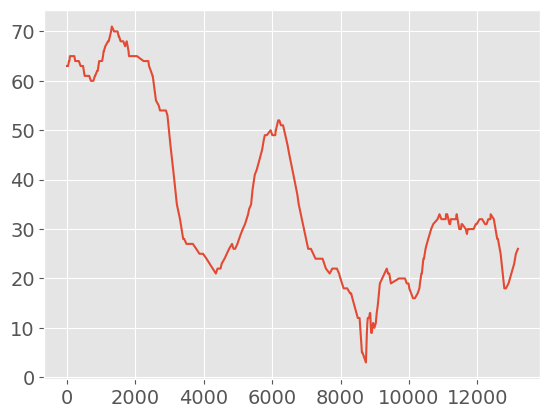

In [178]:
plt.plot(elv[:,0],elv[:,1])